In [1]:
import numpy.polynomial.polynomial as poly
import pandas as pd
import scipy
import os
import xarray as xr
import glob
import numpy as np
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import netCDF4 as nc
# Your code continues here
import scipy.signal as signal

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
def get_data(filename, variablename):
    try: 
        ds = xr.open_dataset(filename).sel(lat=slice(15,-15))
    except ValueError:
        ds = xr.open_dataset(filename, decode_times=False)
    
    return ds[variablename]


fili = r"G:/code_daily/wave&precipitation/data/olr.day.mean.nc" 
vari = "olr"

data = get_data(fili, vari).interpolate_na(dim='time',method="linear")

In [3]:
data

<xarray.DataArray 'olr' (time: 17746, lat: 13, lon: 144)>
array([[[309.94998, 295.69998, 301.26   , ..., 271.61   , 265.01   ,
         306.61   ],
        [260.8    , 255.7    , 242.60999, ..., 217.95   , 228.5    ,
         248.4    ],
        [225.5    , 245.35999, 241.54999, ..., 228.7    , 232.79999,
         234.35999],
        ...,
        [286.36   , 286.55   , 281.94998, ..., 285.44998, 285.8    ,
         284.01   ],
        [270.8    , 281.19998, 281.51   , ..., 284.26   , 278.19998,
         278.61   ],
        [271.55   , 270.4    , 274.21   , ..., 274.36   , 281.55   ,
         279.05   ]],

       [[306.41998, 290.8    , 279.16998, ..., 266.26   , 269.72998,
         305.86   ],
        [256.36   , 226.39   , 223.23   , ..., 259.21   , 236.85999,
         250.35999],
        [225.93   , 210.32999, 210.78   , ..., 235.4    , 218.04999,
         235.54999],
...
        [276.5    , 272.     , 262.5    , ..., 271.25   , 271.     ,
         273.25   ],
        [273.25   , 272.85   , 268.75   , ..., 267.35   , 267.5    ,
         270.6    ],
        [270.5    , 269.25   , 265.     , ..., 269.5    , 270.5    ,
         271.     ]],

       [[275.     , 281.5    , 286.     , ..., 215.5    , 196.5    ,
         266.75   ],
        [289.75   , 288.85   , 290.     , ..., 251.1    , 272.25   ,
         284.1    ],
        [293.     , 290.75   , 295.5    , ..., 261.     , 247.5    ,
         289.5    ],
        ...,
        [276.5    , 272.     , 262.5    , ..., 271.25   , 271.     ,
         273.25   ],
        [273.25   , 272.85   , 268.75   , ..., 267.35   , 267.5    ,
         270.6    ],
        [270.5    , 269.25   , 265.     , ..., 269.5    , 270.5    ,
         271.     ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 15.0 12.5 10.0 7.5 5.0 ... -7.5 -10.0 -12.5 -15.0
  * time     (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2022-12-31
Attributes:
    units:         W/m^2
    var_desc:      Outgoing Longwave Radiation
    precision:     2
    dataset:       NOAA Interpolated OLR
    level_desc:    Other
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [  0. 500.]
    long_name:     Daily Mean OLR
    actual_range:  [ 64.75 344.5 ]

In [4]:
nDayWin = 96
fCrit = 1. / nDayWin

    

In [7]:

# Remove long term linear trend
long_mean = np.mean(data.data, axis=0)
detrend = signal.detrend(data, axis=0, type='linear')
array_dt = detrend + long_mean


In [9]:
nDayTot = data.shape[0]

In [17]:


fourier = np.fft.rfft(array_dt, axis=0)
fourier_mean = np.copy(fourier[0, :, :])
freq = np.fft.rfftfreq(array_dt.shape[0], 1. / 1)
ind = np.where(freq <= fCrit)[0]
fourier[ind, :, :] = 0.0
fourier[0, :, :] = fourier_mean
array_dt = np.fft.irfft(fourier, axis=0)

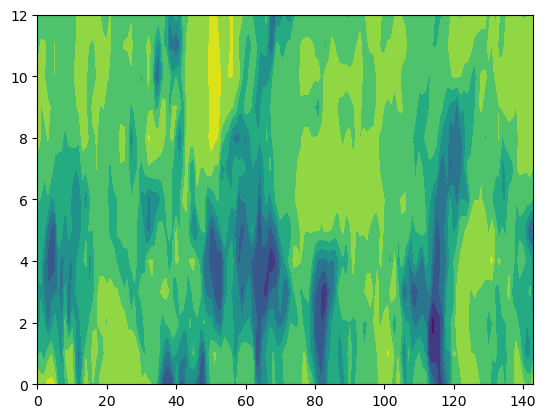

In [18]:
plt.contourf(array_dt[0])

In [23]:

dimz = data.sizes
ntim = dimz['time']
time_ax = list(data.dims).index('time')
# Method 1: Uses the complex FFT, returns the negative frequencies too, but they
# should be redundant b/c they are conjugate of positive ones.
cf = np.fft.fft(data.values, axis=time_ax)
freq = np.fft.fftfreq(ntim, 1)
cf[(freq != 0)&(np.abs(freq) < fCrit), ...] = 0.0 # keeps the mean
z = np.fft.ifft(cf, n=ntim, axis=0)
# Method 2: Uses the real FFT. In this case, 
# cf = np.fft.rfft(data.values, axis=time_ax)
# freq = np.linspace(1, (ntim*spd)//2, (ntim*spd)//2) / ntim
# fcrit_ndx = np.argwhere(freq < fCrit).max()
# if fcrit_ndx > 1:
#     cf[1:fcrit_ndx+1, ...] = 0.0
# z = np.fft.irfft(cf, n=ntim, axis=0)
# z = xr.DataArray(z.real, dims=data.dims, coords=data.coords)


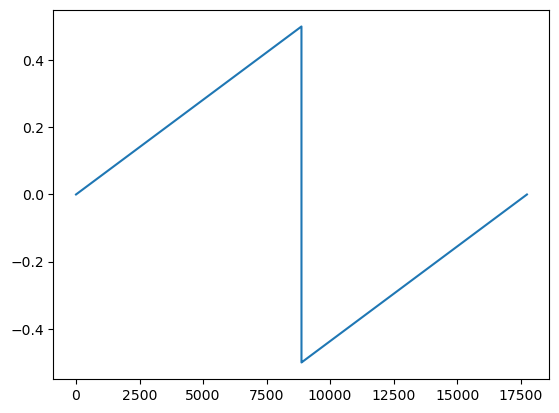

In [24]:
plt.plot(freq)

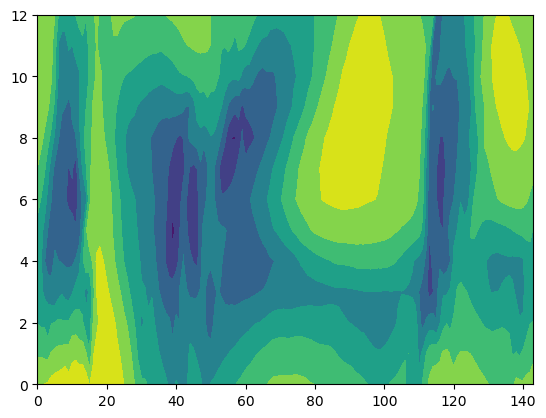

In [34]:
plt.contourf(cf[0])

d:\anaconda\ANACONDA\envs\py311\Lib\site-packages\matplotlib\contour.py:1578: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
d:\anaconda\ANACONDA\envs\py311\Lib\site-packages\matplotlib\contour.py:1579: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
d:\anaconda\ANACONDA\envs\py311\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


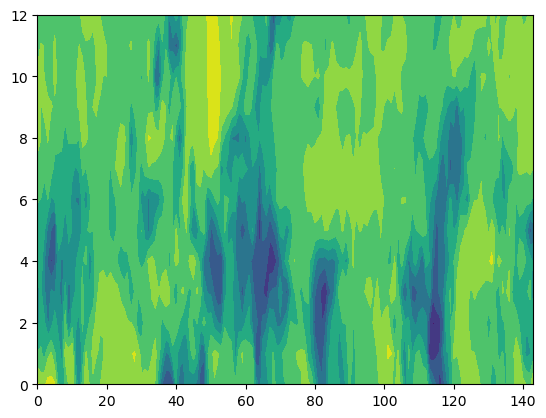

In [20]:
plt.contourf(z[0])